# Commercial FRPA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
import re, pathlib

FILE = "Link Budget Commercial Last TropoSCi Disabled.csv"            

lines = [
    ln.replace('"', '')                       
    for ln in pathlib.Path(FILE)
                 .read_text(encoding="utf-8", errors="ignore")
                 .splitlines()
    if ln.strip()                             
]

header_idx  = next(i for i, ln in enumerate(lines) if "Time (UTCG)" in ln)
header_line = lines[header_idx]

block_markers = [
    i for i, ln in enumerate(lines)
    if ln.startswith("Satellite/") and "Link Information" in ln
]

all_blocks = []

for bi, start in enumerate(block_markers):
    sat_name = re.sub(r'^Satellite/(.+?)\s+Link Information.*', r'\1', lines[start])

    end = block_markers[bi + 1] if bi + 1 < len(block_markers) else len(lines)

    data_rows = [
        r for r in lines[start + 1 : end]
        if (
            not r.startswith("Satellite/")       
            and "Link Information" not in r
            and not r.startswith("Time (UTCG)")  
        )
    ]

    if not data_rows:
        continue  

    block_text = (
        "SatelliteName," + header_line + "\n" +
        "\n".join(f"{sat_name},{row}" for row in data_rows)
    )

    df_block = pd.read_csv(StringIO(block_text), sep=None, engine="python")
    df_block["SatelliteName"] = sat_name      
    all_blocks.append(df_block)

if not all_blocks:
    raise RuntimeError("❌  No data blocks parsed – check the file path and format.")


df = pd.concat(all_blocks, ignore_index=True)
df.columns = df.columns.str.strip()            

time_col = next(c for c in df.columns if "Time" in c and "UTC" in c)

sample = str(df[time_col].iloc[0])
if re.match(r"^\d\d:\d\d", sample):            
    df["Time"] = pd.to_timedelta(df[time_col].str.replace(":", "h", 1))
else:
    df["Time"] = pd.to_datetime(df[time_col], errors="coerce")                  


satellites = df["SatelliteName"].unique()
palette    = plt.colormaps.get_cmap("tab20")(np.linspace(0, 1, len(satellites)))



### Receiver Gain

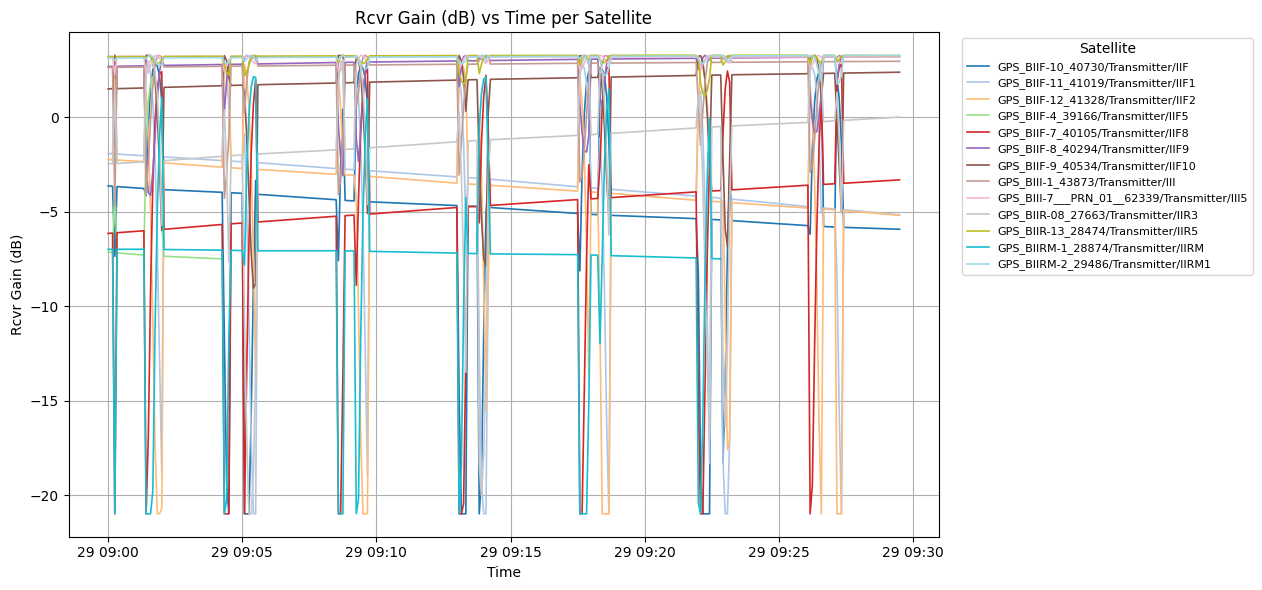

In [2]:
prop_col = next(c for c in df.columns if "Rcvr Gain (dB)" in c)                

metric_col = prop_col 
plt.figure(figsize=(16, 6))
for sat, color in zip(satellites, palette):
    dsub = df[df["SatelliteName"] == sat]
    plt.plot(
        dsub["Time"], dsub[metric_col],
        label=sat, color=color, linewidth=1.2
    )

title_map = {
    prop_col: "Rcvr Gain (dB)",
}
plt.title(f"{title_map.get(metric_col, metric_col)} vs Time per Satellite")
xlabel = "Time" if df["Time"].dtype.kind == "M" else "Elapsed time (hh:mm)"
plt.xlabel(xlabel)
plt.ylabel(title_map.get(metric_col, metric_col))
plt.grid(True)
plt.legend(
    title="Satellite",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize=8
)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

### C/N Density

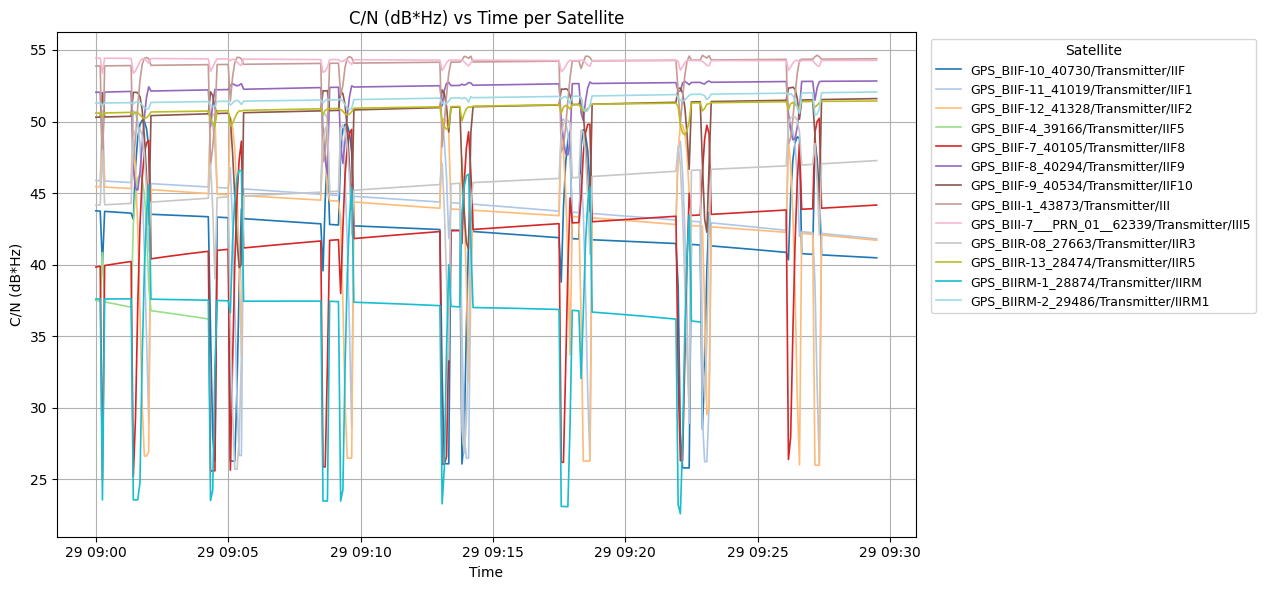

In [3]:
cn_col = [c for c in df.columns if "C/No" in c and "Io" not in c][0]
sat_names = df["SatelliteName"].unique()
colors    = plt.colormaps.get_cmap("tab20")(np.linspace(0, 1, len(sat_names)))

plt.figure(figsize=(16, 6))
for sat, color in zip(sat_names, colors):
    subset = df[df["SatelliteName"] == sat]
    plt.plot(subset["Time"], subset[cn_col], label=sat, color=color, linewidth=1.2)
plt.title("C/N (dB*Hz) vs Time per Satellite")
plt.xlabel("Time")
plt.ylabel("C/N (dB*Hz)")
plt.legend(title="Satellite", bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=9)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


### C/N+I Density

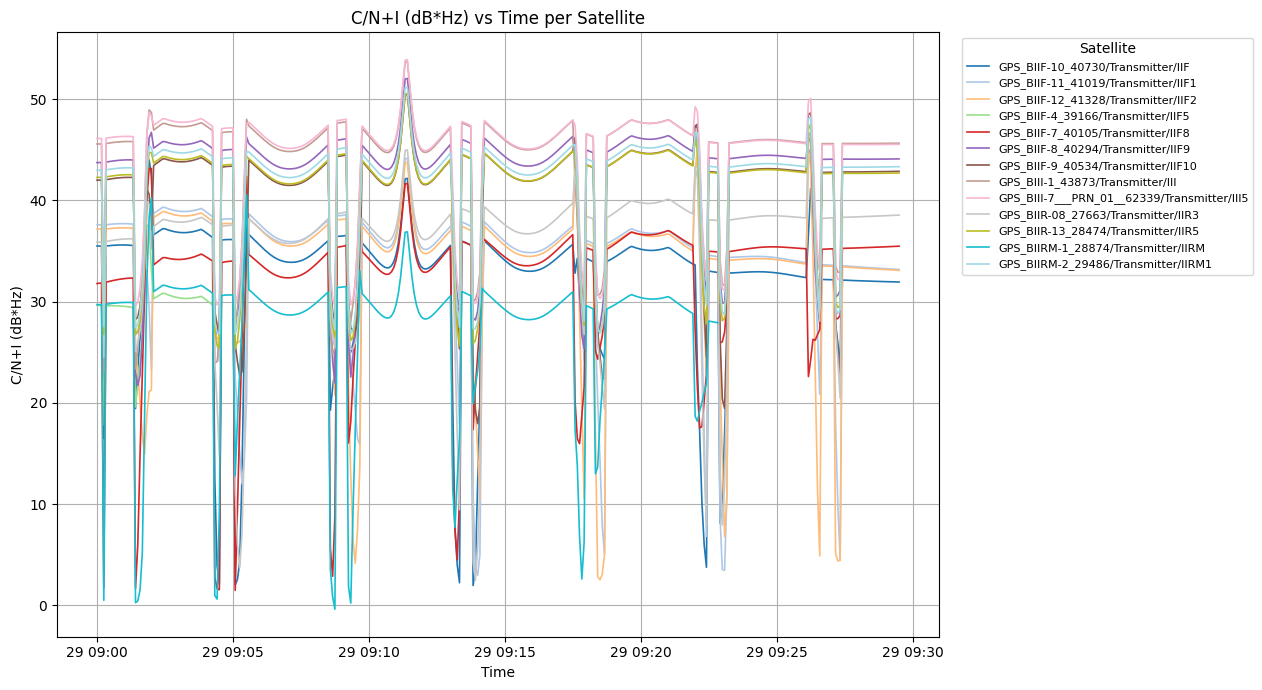

In [4]:
cni_col = [c for c in df.columns
           if "C/(No+Io" in c or "C/(N+I" in c][0]   

metric_col = cni_col                

sat_names = df["SatelliteName"].unique()
colors    = plt.colormaps.get_cmap("tab20")(np.linspace(0, 1, len(sat_names)))

plt.figure(figsize=(16, 7))
for sat, color in zip(sat_names, colors):
    subset = df[df["SatelliteName"] == sat]
    plt.plot(
        subset["Time"], subset[metric_col],
        label=sat, color=color, linewidth=1.2
    )

plt.title("C/N+I (dB*Hz) vs Time per Satellite")
plt.xlabel("Time" if df["Time"].dtype.kind == "M" else "Elapsed time (hh:mm)")
plt.ylabel("C/N+I (dB*Hz)")
plt.grid(True)
plt.legend(title="Satellite", bbox_to_anchor=(1.02, 1),
           loc="upper left", fontsize=8)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

### Medians

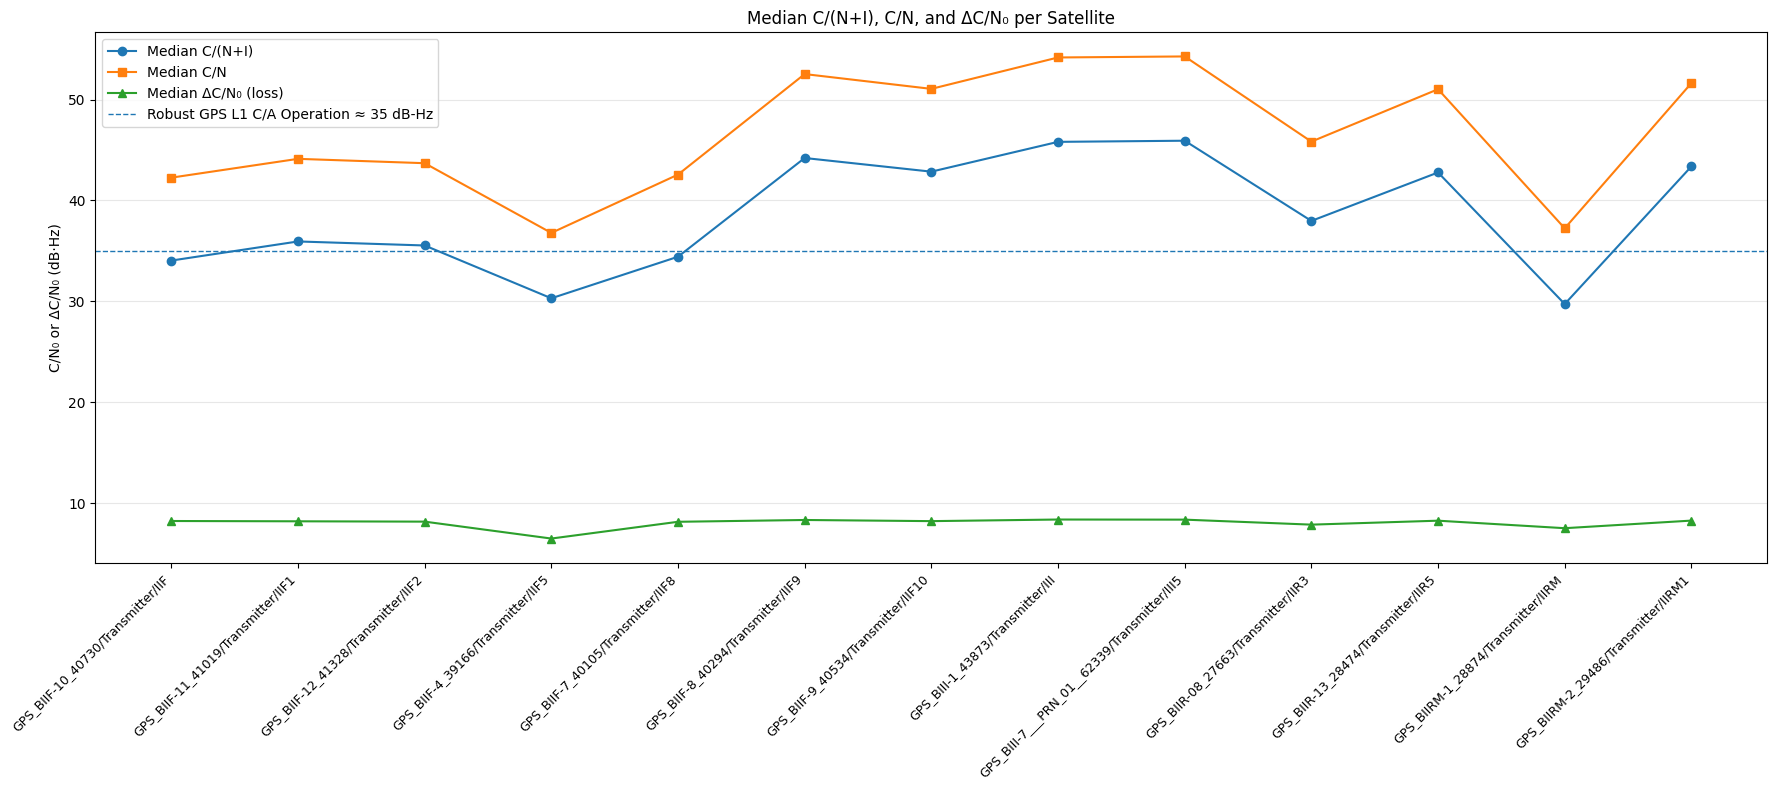

In [5]:
import numpy as np
import matplotlib.pyplot as plt

g = df.groupby("SatelliteName")
med_cni = g[cni_col].median().sort_index()          
med_cn  = g[cn_col].median().reindex(med_cni.index) 

sat_names = med_cni.index.tolist()
x = np.arange(len(sat_names))

loss_dbhz = med_cn - med_cni   

# --- Usable GPS L1 C/A "rule-of-thumb" threshold ---
ROBUST_OP = 35.0  # dB-Hz

plt.figure(figsize=(18, 8))
plt.plot(x, med_cni.values, 'o-', label='Median C/(N+I)')
plt.plot(x, med_cn.values,  's-', label='Median C/N')
plt.plot(x, loss_dbhz.values, '^-', label='Median ΔC/N₀ (loss)')
plt.axhline(ROBUST_OP, linestyle='--', linewidth=1,
            label='Robust GPS L1 C/A Operation ≈ 35 dB-Hz')

plt.xticks(x, sat_names, rotation=45, ha='right', fontsize=9)
plt.ylabel("C/N₀ or ΔC/N₀ (dB·Hz)")
plt.title("Median C/(N+I), C/N, and ΔC/N₀ per Satellite")
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

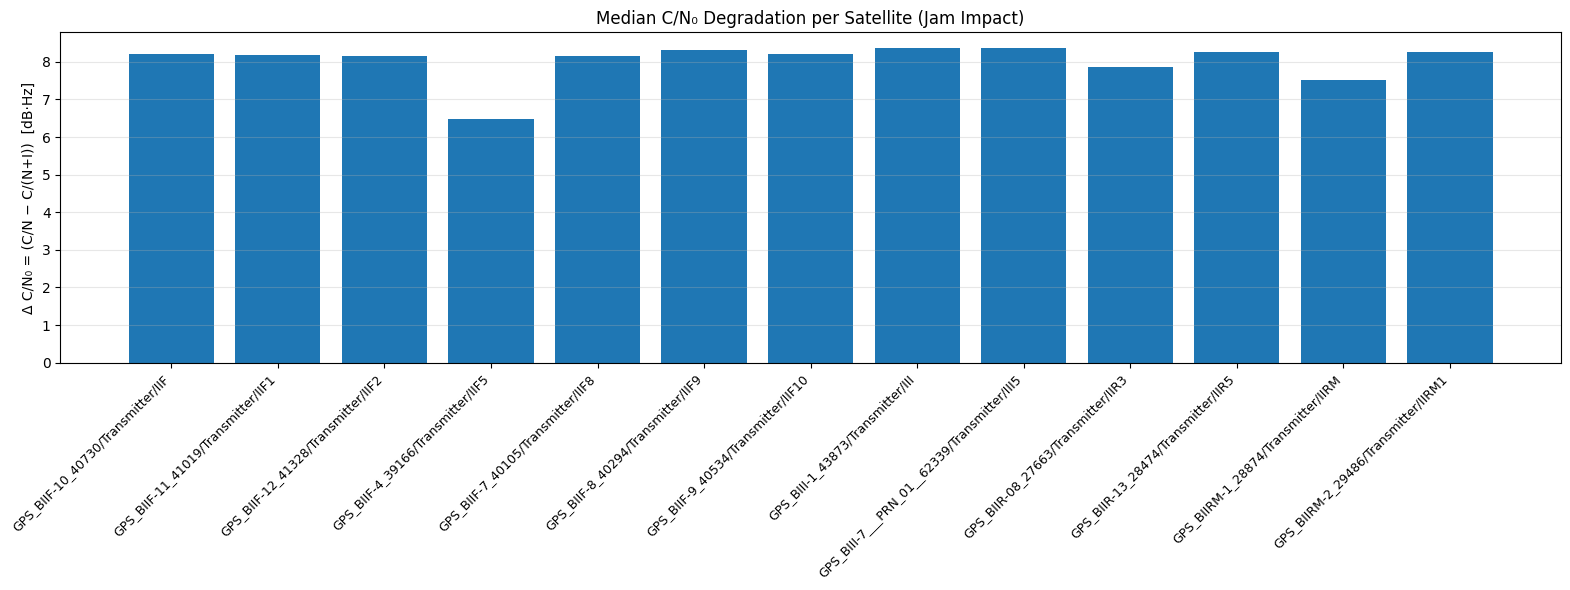

Median loss across satellites: 8.21 dB-Hz
Mean loss across satellites:   8.02 dB-Hz
Min / Max loss:                6.48 / 8.37 dB-Hz


In [6]:
plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(sat_names)), loss_dbhz.values)
plt.xticks(np.arange(len(sat_names)), sat_names, rotation=45, ha='right', fontsize=9)
plt.ylabel("Δ C/N₀ = (C/N − C/(N+I))  [dB·Hz]")
plt.title("Median C/N₀ Degradation per Satellite (Jam Impact)")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Median loss across satellites: {:.2f} dB-Hz".format(loss_dbhz.median()))
print("Mean loss across satellites:   {:.2f} dB-Hz".format(loss_dbhz.mean()))
print("Min / Max loss:                {:.2f} / {:.2f} dB-Hz".format(loss_dbhz.min(), loss_dbhz.max()))


# Commercial CRPA

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
import re, pathlib

FILE = "Link Budget Commercial Last TropoSCi DisabledCRPA.csv"            

lines = [
    ln.replace('"', '')                       
    for ln in pathlib.Path(FILE)
                 .read_text(encoding="utf-8", errors="ignore")
                 .splitlines()
    if ln.strip()                             
]

header_idx  = next(i for i, ln in enumerate(lines) if "Time (UTCG)" in ln)
header_line = lines[header_idx]

block_markers = [
    i for i, ln in enumerate(lines)
    if ln.startswith("Satellite/") and "Link Information" in ln
]

all_blocks = []

for bi, start in enumerate(block_markers):
    sat_name = re.sub(r'^Satellite/(.+?)\s+Link Information.*', r'\1', lines[start])

    end = block_markers[bi + 1] if bi + 1 < len(block_markers) else len(lines)

    data_rows = [
        r for r in lines[start + 1 : end]
        if (
            not r.startswith("Satellite/")       
            and "Link Information" not in r
            and not r.startswith("Time (UTCG)")  
        )
    ]

    if not data_rows:
        continue  

    block_text = (
        "SatelliteName," + header_line + "\n" +
        "\n".join(f"{sat_name},{row}" for row in data_rows)
    )

    df_block = pd.read_csv(StringIO(block_text), sep=None, engine="python")
    df_block["SatelliteName"] = sat_name      
    all_blocks.append(df_block)

if not all_blocks:
    raise RuntimeError("❌  No data blocks parsed – check the file path and format.")


df = pd.concat(all_blocks, ignore_index=True)
df.columns = df.columns.str.strip()            

time_col = next(c for c in df.columns if "Time" in c and "UTC" in c)

sample = str(df[time_col].iloc[0])
if re.match(r"^\d\d:\d\d", sample):            
    df["Time"] = pd.to_timedelta(df[time_col].str.replace(":", "h", 1))
else:
    df["Time"] = pd.to_datetime(df[time_col], errors="coerce")                  


satellites = df["SatelliteName"].unique()
palette    = plt.colormaps.get_cmap("tab20")(np.linspace(0, 1, len(satellites)))

### Medians

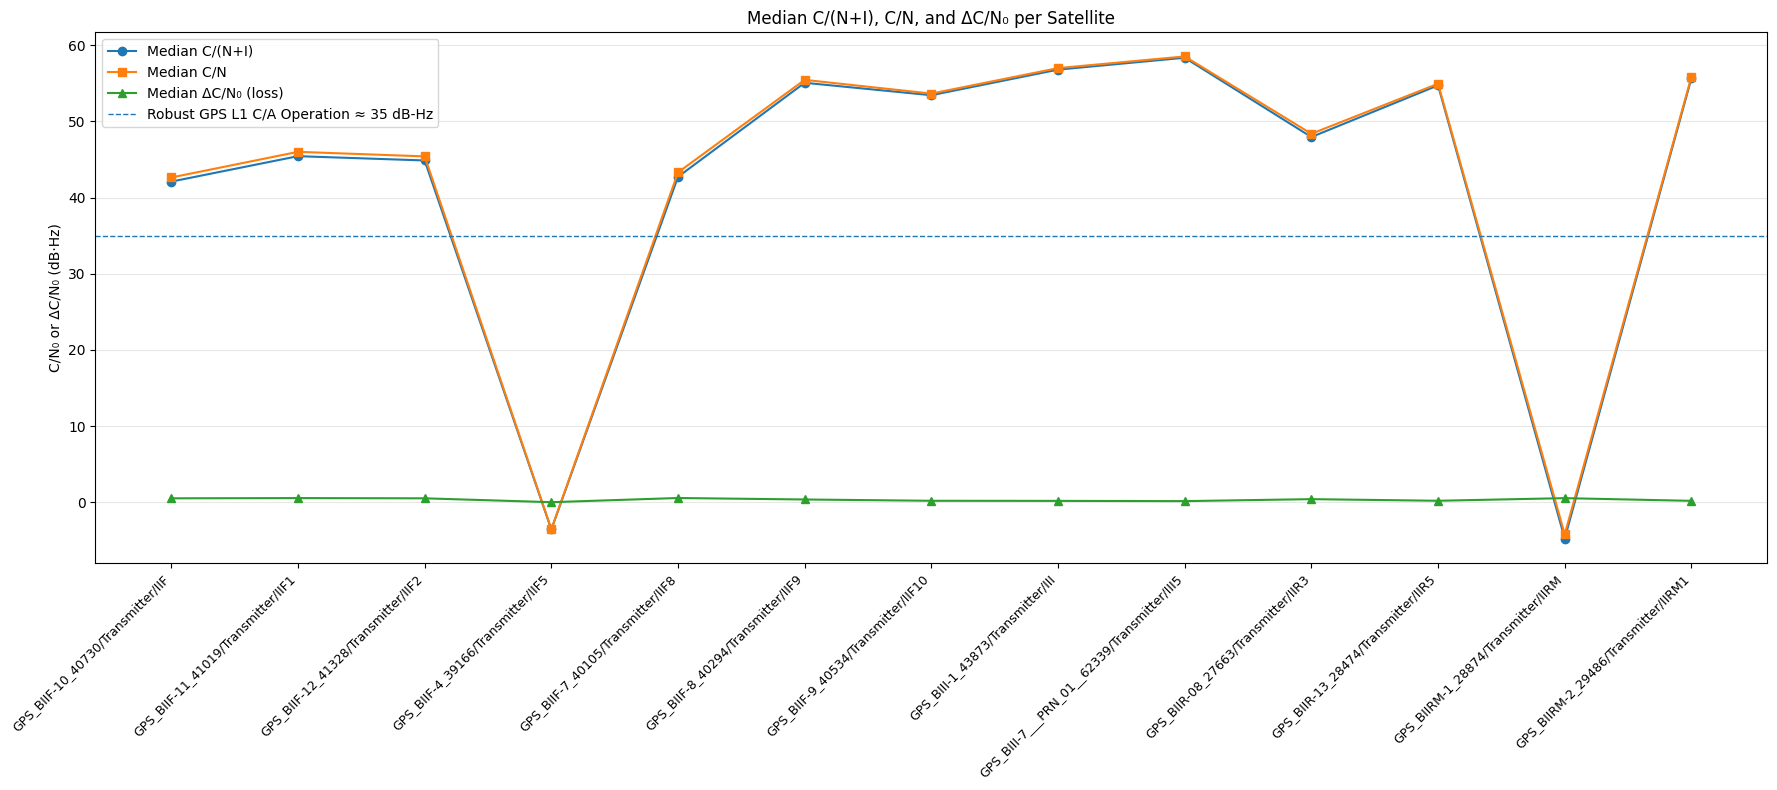

In [8]:
import numpy as np
import matplotlib.pyplot as plt

g = df.groupby("SatelliteName")
med_cni = g[cni_col].median().sort_index()          
med_cn  = g[cn_col].median().reindex(med_cni.index) 

sat_names = med_cni.index.tolist()
x = np.arange(len(sat_names))

loss_dbhz = med_cn - med_cni   

# --- Usable GPS L1 C/A "rule-of-thumb" threshold ---
ROBUST_OP = 35.0  # dB-Hz

plt.figure(figsize=(18, 8))
plt.plot(x, med_cni.values, 'o-', label='Median C/(N+I)')
plt.plot(x, med_cn.values,  's-', label='Median C/N')
plt.plot(x, loss_dbhz.values, '^-', label='Median ΔC/N₀ (loss)')
plt.axhline(ROBUST_OP, linestyle='--', linewidth=1,
            label='Robust GPS L1 C/A Operation ≈ 35 dB-Hz')

plt.xticks(x, sat_names, rotation=45, ha='right', fontsize=9)
plt.ylabel("C/N₀ or ΔC/N₀ (dB·Hz)")
plt.title("Median C/(N+I), C/N, and ΔC/N₀ per Satellite")
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

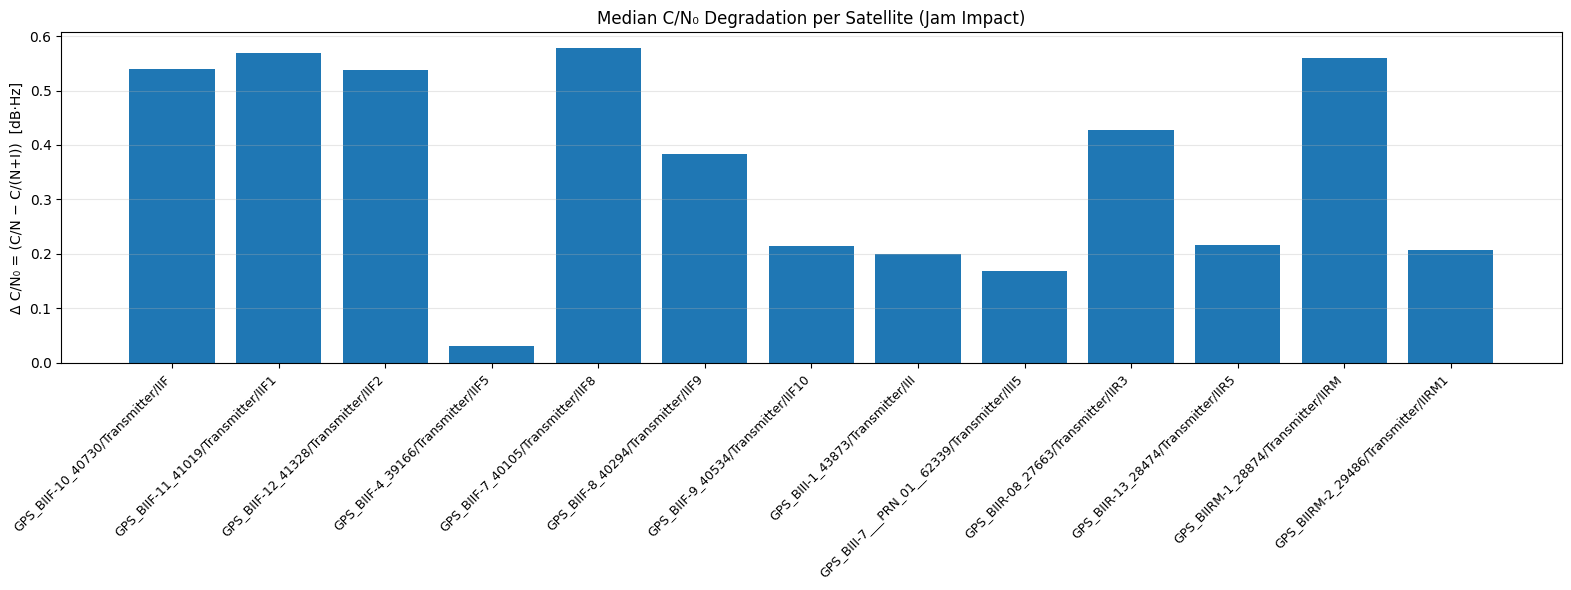

Median loss across satellites: 0.38 dB-Hz
Mean loss across satellites:   0.36 dB-Hz
Min / Max loss:                0.03 / 0.58 dB-Hz


In [9]:
plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(sat_names)), loss_dbhz.values)
plt.xticks(np.arange(len(sat_names)), sat_names, rotation=45, ha='right', fontsize=9)
plt.ylabel("Δ C/N₀ = (C/N − C/(N+I))  [dB·Hz]")
plt.title("Median C/N₀ Degradation per Satellite (Jam Impact)")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Median loss across satellites: {:.2f} dB-Hz".format(loss_dbhz.median()))
print("Mean loss across satellites:   {:.2f} dB-Hz".format(loss_dbhz.mean()))
print("Min / Max loss:                {:.2f} / {:.2f} dB-Hz".format(loss_dbhz.min(), loss_dbhz.max()))

# Dir FRPA

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
import re, pathlib

FILE = "Link Budget Commercial Last TropoSCi DisabledD.csv"            

lines = [
    ln.replace('"', '')                       
    for ln in pathlib.Path(FILE)
                 .read_text(encoding="utf-8", errors="ignore")
                 .splitlines()
    if ln.strip()                             
]

header_idx  = next(i for i, ln in enumerate(lines) if "Time (UTCG)" in ln)
header_line = lines[header_idx]

block_markers = [
    i for i, ln in enumerate(lines)
    if ln.startswith("Satellite/") and "Link Information" in ln
]

all_blocks = []

for bi, start in enumerate(block_markers):
    sat_name = re.sub(r'^Satellite/(.+?)\s+Link Information.*', r'\1', lines[start])

    end = block_markers[bi + 1] if bi + 1 < len(block_markers) else len(lines)

    data_rows = [
        r for r in lines[start + 1 : end]
        if (
            not r.startswith("Satellite/")       
            and "Link Information" not in r
            and not r.startswith("Time (UTCG)")  
        )
    ]

    if not data_rows:
        continue  

    block_text = (
        "SatelliteName," + header_line + "\n" +
        "\n".join(f"{sat_name},{row}" for row in data_rows)
    )

    df_block = pd.read_csv(StringIO(block_text), sep=None, engine="python")
    df_block["SatelliteName"] = sat_name      
    all_blocks.append(df_block)

if not all_blocks:
    raise RuntimeError("❌  No data blocks parsed – check the file path and format.")


df = pd.concat(all_blocks, ignore_index=True)
df.columns = df.columns.str.strip()            

time_col = next(c for c in df.columns if "Time" in c and "UTC" in c)

sample = str(df[time_col].iloc[0])
if re.match(r"^\d\d:\d\d", sample):            
    df["Time"] = pd.to_timedelta(df[time_col].str.replace(":", "h", 1))
else:
    df["Time"] = pd.to_datetime(df[time_col], errors="coerce")                  


satellites = df["SatelliteName"].unique()
palette    = plt.colormaps.get_cmap("tab20")(np.linspace(0, 1, len(satellites)))



### Medians

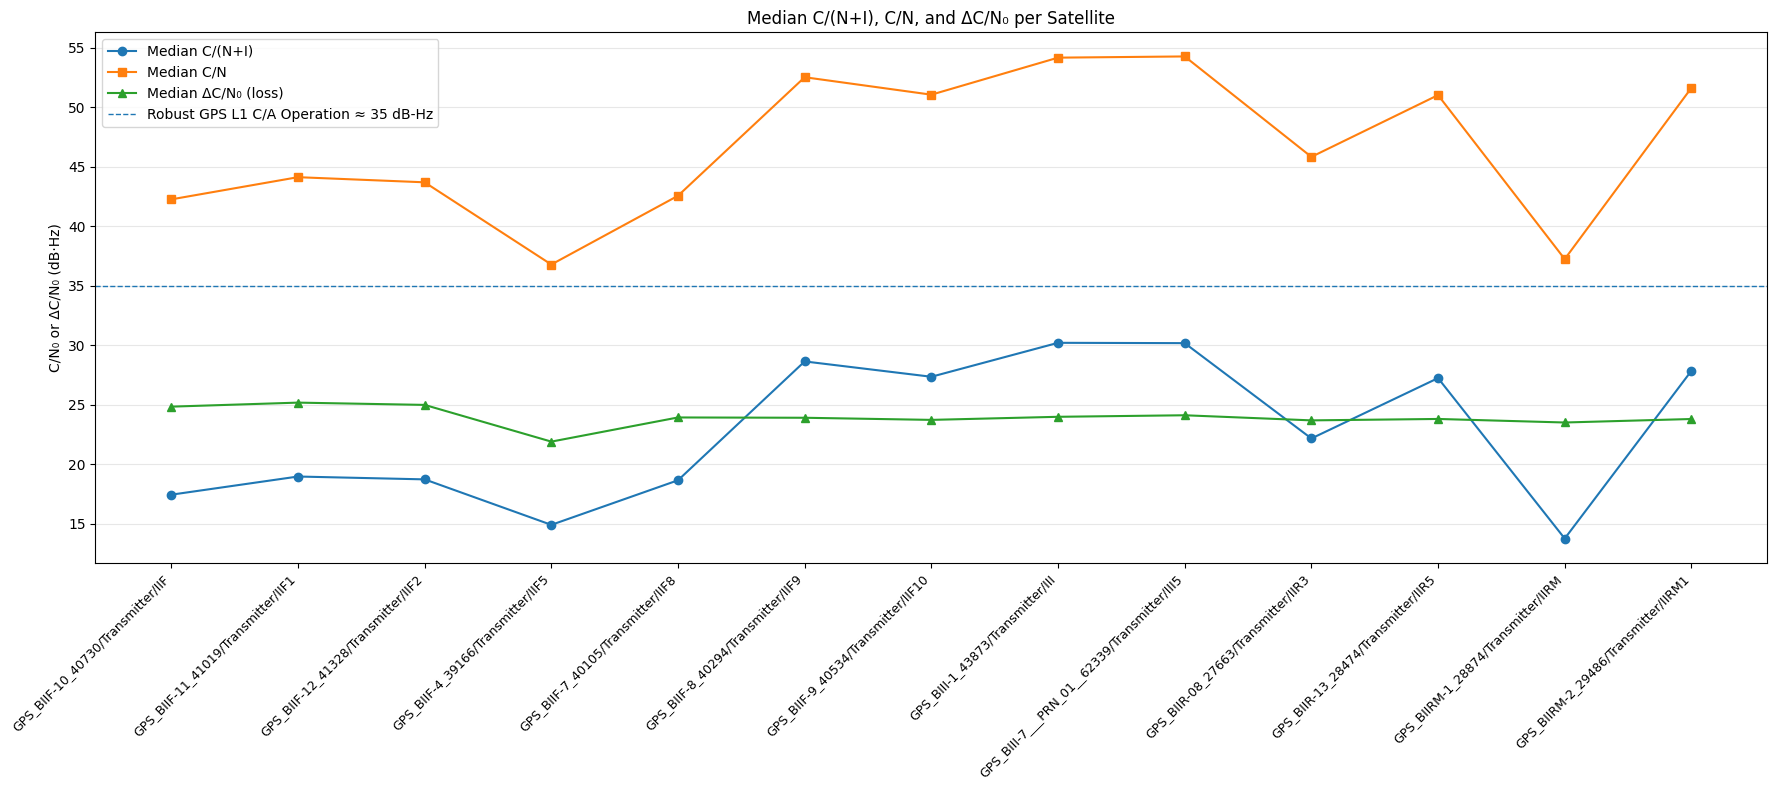

In [11]:
import numpy as np
import matplotlib.pyplot as plt

g = df.groupby("SatelliteName")
med_cni = g[cni_col].median().sort_index()          
med_cn  = g[cn_col].median().reindex(med_cni.index) 

sat_names = med_cni.index.tolist()
x = np.arange(len(sat_names))

loss_dbhz = med_cn - med_cni   

# --- Usable GPS L1 C/A "rule-of-thumb" threshold ---
ROBUST_OP = 35.0  # dB-Hz

plt.figure(figsize=(18, 8))
plt.plot(x, med_cni.values, 'o-', label='Median C/(N+I)')
plt.plot(x, med_cn.values,  's-', label='Median C/N')
plt.plot(x, loss_dbhz.values, '^-', label='Median ΔC/N₀ (loss)')
plt.axhline(ROBUST_OP, linestyle='--', linewidth=1,
            label='Robust GPS L1 C/A Operation ≈ 35 dB-Hz')

plt.xticks(x, sat_names, rotation=45, ha='right', fontsize=9)
plt.ylabel("C/N₀ or ΔC/N₀ (dB·Hz)")
plt.title("Median C/(N+I), C/N, and ΔC/N₀ per Satellite")
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


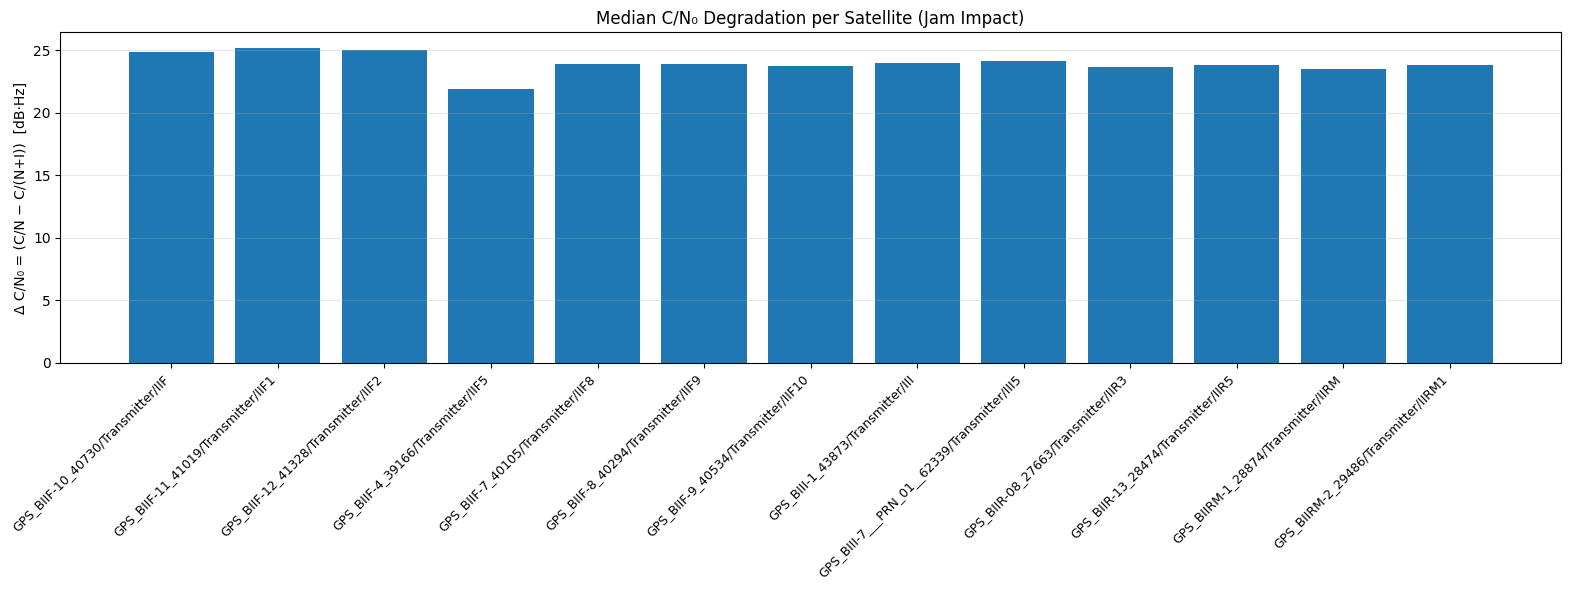

Median loss across satellites: 23.89 dB-Hz
Mean loss across satellites:   23.94 dB-Hz
Min / Max loss:                21.89 / 25.17 dB-Hz


In [12]:
plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(sat_names)), loss_dbhz.values)
plt.xticks(np.arange(len(sat_names)), sat_names, rotation=45, ha='right', fontsize=9)
plt.ylabel("Δ C/N₀ = (C/N − C/(N+I))  [dB·Hz]")
plt.title("Median C/N₀ Degradation per Satellite (Jam Impact)")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Median loss across satellites: {:.2f} dB-Hz".format(loss_dbhz.median()))
print("Mean loss across satellites:   {:.2f} dB-Hz".format(loss_dbhz.mean()))
print("Min / Max loss:                {:.2f} / {:.2f} dB-Hz".format(loss_dbhz.min(), loss_dbhz.max()))


# Dir CRPA

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
import re, pathlib

FILE = "Link Budget Commercial Last TropoSCi DisabledCRPAD.csv"            

lines = [
    ln.replace('"', '')                       
    for ln in pathlib.Path(FILE)
                 .read_text(encoding="utf-8", errors="ignore")
                 .splitlines()
    if ln.strip()                             
]

header_idx  = next(i for i, ln in enumerate(lines) if "Time (UTCG)" in ln)
header_line = lines[header_idx]

block_markers = [
    i for i, ln in enumerate(lines)
    if ln.startswith("Satellite/") and "Link Information" in ln
]

all_blocks = []

for bi, start in enumerate(block_markers):
    sat_name = re.sub(r'^Satellite/(.+?)\s+Link Information.*', r'\1', lines[start])

    end = block_markers[bi + 1] if bi + 1 < len(block_markers) else len(lines)

    data_rows = [
        r for r in lines[start + 1 : end]
        if (
            not r.startswith("Satellite/")       
            and "Link Information" not in r
            and not r.startswith("Time (UTCG)")  
        )
    ]

    if not data_rows:
        continue  

    block_text = (
        "SatelliteName," + header_line + "\n" +
        "\n".join(f"{sat_name},{row}" for row in data_rows)
    )

    df_block = pd.read_csv(StringIO(block_text), sep=None, engine="python")
    df_block["SatelliteName"] = sat_name      
    all_blocks.append(df_block)

if not all_blocks:
    raise RuntimeError("❌  No data blocks parsed – check the file path and format.")


df = pd.concat(all_blocks, ignore_index=True)
df.columns = df.columns.str.strip()            

time_col = next(c for c in df.columns if "Time" in c and "UTC" in c)

sample = str(df[time_col].iloc[0])
if re.match(r"^\d\d:\d\d", sample):            
    df["Time"] = pd.to_timedelta(df[time_col].str.replace(":", "h", 1))
else:
    df["Time"] = pd.to_datetime(df[time_col], errors="coerce")                  


satellites = df["SatelliteName"].unique()
palette    = plt.colormaps.get_cmap("tab20")(np.linspace(0, 1, len(satellites)))



### Medians

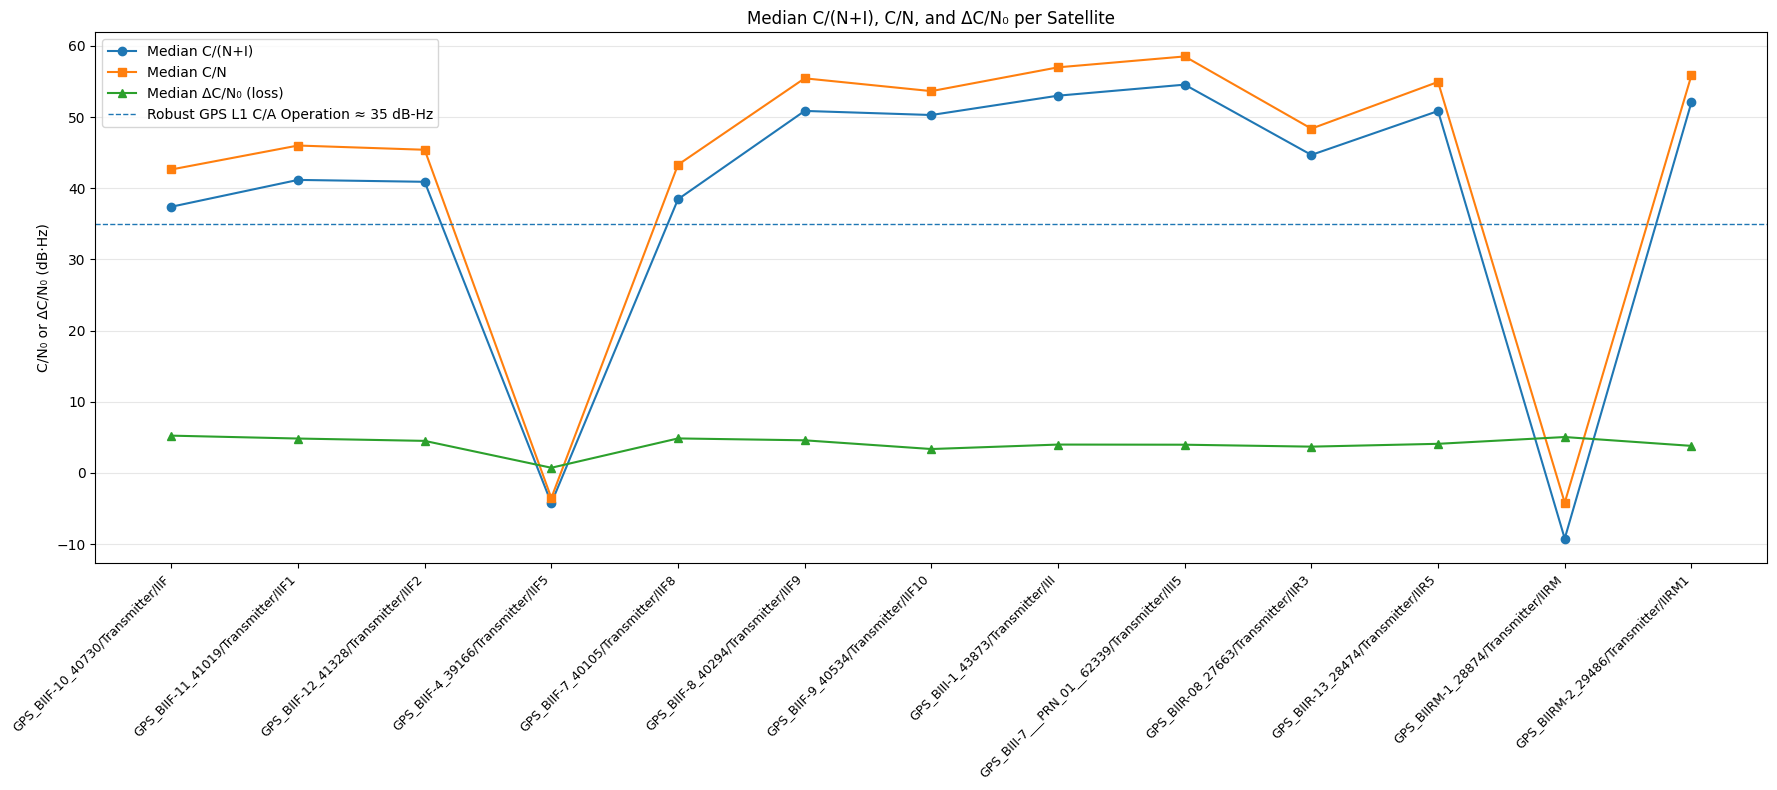

In [14]:
import numpy as np
import matplotlib.pyplot as plt

g = df.groupby("SatelliteName")
med_cni = g[cni_col].median().sort_index()          
med_cn  = g[cn_col].median().reindex(med_cni.index) 

sat_names = med_cni.index.tolist()
x = np.arange(len(sat_names))

loss_dbhz = med_cn - med_cni   

# --- Usable GPS L1 C/A "rule-of-thumb" threshold ---
ROBUST_OP = 35.0  # dB-Hz

plt.figure(figsize=(18, 8))
plt.plot(x, med_cni.values, 'o-', label='Median C/(N+I)')
plt.plot(x, med_cn.values,  's-', label='Median C/N')
plt.plot(x, loss_dbhz.values, '^-', label='Median ΔC/N₀ (loss)')
plt.axhline(ROBUST_OP, linestyle='--', linewidth=1,
            label='Robust GPS L1 C/A Operation ≈ 35 dB-Hz')

plt.xticks(x, sat_names, rotation=45, ha='right', fontsize=9)
plt.ylabel("C/N₀ or ΔC/N₀ (dB·Hz)")
plt.title("Median C/(N+I), C/N, and ΔC/N₀ per Satellite")
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


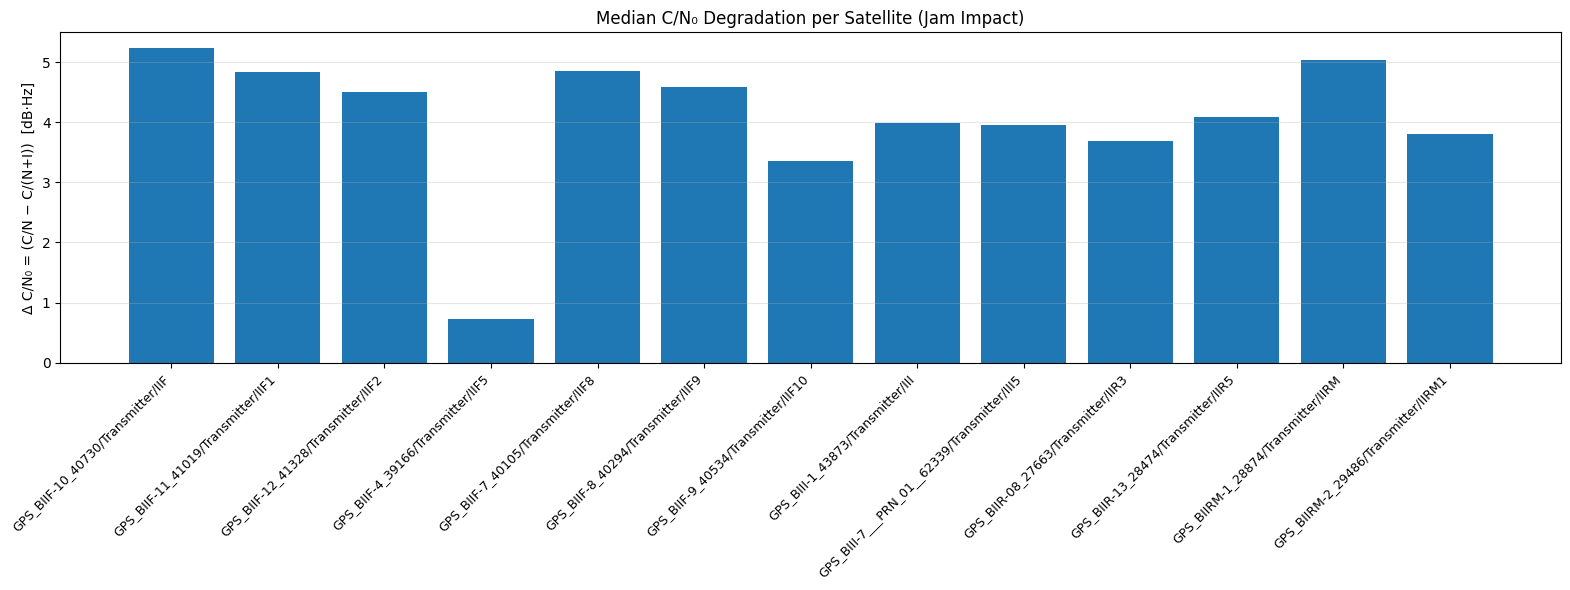

Median loss across satellites: 4.09 dB-Hz
Mean loss across satellites:   4.05 dB-Hz
Min / Max loss:                0.72 / 5.24 dB-Hz


In [15]:
plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(sat_names)), loss_dbhz.values)
plt.xticks(np.arange(len(sat_names)), sat_names, rotation=45, ha='right', fontsize=9)
plt.ylabel("Δ C/N₀ = (C/N − C/(N+I))  [dB·Hz]")
plt.title("Median C/N₀ Degradation per Satellite (Jam Impact)")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


print("Median loss across satellites: {:.2f} dB-Hz".format(loss_dbhz.median()))
print("Mean loss across satellites:   {:.2f} dB-Hz".format(loss_dbhz.mean()))
print("Min / Max loss:                {:.2f} / {:.2f} dB-Hz".format(loss_dbhz.min(), loss_dbhz.max()))
